# Systematics uncertainties on different energy scales
In this notebook the likelihood function used in the joint fit, referred to as _wstat_ (defined in **Poisson data with background measurement** at https://docs.gammapy.org/dev/stats/fit_statistics.html#wstat) and available in `gammapy.stats.fit_statistics`, will be modified to account for the systematic uncertainty on the energy-scale for the different instruments. 

In [1]:
%matplotlib inline
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

## introducing the energy scale in the spectral model
Following Dembiski (http://adsabs.harvard.edu/abs/2017ICRC...35..533D) we introduce an energy-scale factor $z$ defined as
$$
z = \frac{\tilde{E} - E}{E} = \frac{\tilde{E}}{E} - 1
$$
where $\tilde{E}$ is the energy reported by an experiment for the differential flux $d\tilde{\phi}/d\tilde{E}(\tilde{E})$ reported by the experiment. $d\phi/dE(E)$ is the true flux measured at true energy $E$. 
The _apparent_ differential flux we aim to fit is:
$$
\frac{d\tilde{\phi}}{{d\tilde{E}}} = \frac{d \phi}{dE}(\tilde{E}) \frac{dE}{d\tilde{E}}
$$
in terms of the log-parabolic function:
$$
\frac{d\tilde{\phi}}{{d\tilde{E}}} = \phi_0 
\left( \frac{E/(1+z)}{E_0} \right)^{-\Gamma + \beta \log \left( \frac{E/(1+z)}{E_0} \right)} 
\times \left( \frac{1}{1+z}\right)
$$
This modified log-parabola is available in thie repository in `joint_crab.models`.

In [2]:
from joint_crab.models import Log10ParabolaEnergyScale

Let us see how the log-parabolic spectrum is modified by an energy-scale of $\pm20\%$

(1e-15, 1e-11)

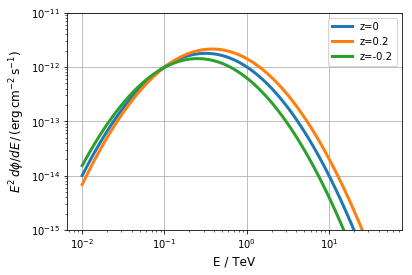

In [3]:
logpar_plus2 = Log10ParabolaEnergyScale(z=+0.2)
logpar_minus2 = Log10ParabolaEnergyScale(z=-0.2)
logpar_0 = Log10ParabolaEnergyScale(z=0)

logpar_0.plot([0.01, 50] * u.TeV, energy_power=2, label="z=0", lw=3)
logpar_plus2.plot([0.01, 50] * u.TeV, energy_power=2, label="z=0.2", lw=3)
logpar_minus2.plot([0.01, 50] * u.TeV, energy_power=2, label="z=-0.2", lw=3)
plt.legend()
plt.xlabel("E / TeV", fontsize=12)
plt.ylabel(
    r"$E^2\,d\phi/dE\,/\,(\mathrm{erg}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1})$",
    fontsize=12,
)
plt.grid()
plt.ylim([1e-15, 1e-11])

The effect of the energy-scale factor is the shift of the spectrum towards lower energies (left of the plot) when negative and towards higher energies (right of the plot) when positive.

## modifying the likelihood
We modify the joint _wstat_ likelihood function to include the distributions of the energy-scale factors per each instrument $z_{\rm instr}$. We assume them to be gaussianly distributed with mean 0 and std. deviation given by the systematic uncertainty on the energy scale estimated by the single instrument: $\delta_{\rm instr}$. 
The total likelihood reads now:
$$
\prod_{\rm instr} L(\phi_0, \Gamma, \beta, z_{\rm instr} | N_{\rm on,\,instr}, N_{\rm off,\,instr}, \alpha_{\rm instr}) \times
\exp \left( -\frac{1}{2}\frac{z_{\rm instr}^2}{\delta_{\rm instr}^2} \right)
$$
where the first term is the _wstat_ likelihood term with the _apparent_ differential flux as assumed spectral model and the second term is the Gaussian constraint on $z_{\rm instr}$.   
The likelihood function is implemented in `joint_crab.statistics` in `all_instruments_energy_scale_wstat`.
We use iminuit to minimize it.

The values we assume to constraint the deltas are fixed in the function implementation to:
```python
delta_fermi = 0.10
delta_magic = 0.15
delta_hess = 0.15
delta_veritas = 0.15
delta_fact = 0.15
```
IACT tipically claim a $15\%$ in the systematics on the energy scale (see paper and reference therein) and we assume a smaller $10 \%$ for _Fermi_-LAT being calibrated instead of the IACTs. 

In [4]:
from joint_crab.systematics import all_instruments_energy_scale_wstat
from iminuit import Minuit

In [5]:
# dictionary with the limits for the different parameters
limits_dict = {
    "amplitude": (1e-15, 1e-9),
    "alpha": (1, 5),
    "beta": (0.001, 1),
    "reference": (0.3, 30),
    "z_fermi": (-0.3, 0.3),
    "z_magic": (-0.3, 0.3),
    "z_hess": (-0.3, 0.3),
    "z_veritas": (-0.3, 0.3),
    "z_fact": (-0.3, 0.3),
}

# minimize the likelihood
m = Minuit(
    all_instruments_energy_scale_wstat,
    errordef=1,
    amplitude=3e-12,
    reference=1,
    alpha=2.4,
    beta=0.2,
    z_fermi=0.0,
    z_magic=0.0,
    z_hess=0.0,
    z_veritas=0.0,
    z_fact=0.0,
    fix_reference=True,
    error_amplitude=1e-13,
    error_alpha=0.01,
    error_beta=0.001,
    error_reference=0.0,
    error_z_fermi=0.001,
    error_z_magic=0.001,
    error_z_hess=0.001,
    error_z_veritas=0.001,
    error_z_fact=0.001,
    limit_amplitude=limits_dict["amplitude"],
    limit_alpha=limits_dict["alpha"],
    limit_beta=limits_dict["beta"],
    limit_reference=limits_dict["reference"],
    limit_z_fermi=limits_dict["z_fermi"],
    limit_z_magic=limits_dict["z_magic"],
    limit_z_hess=limits_dict["z_hess"],
    limit_z_veritas=limits_dict["z_veritas"],
    limit_z_fact=limits_dict["z_fact"],
)

In [6]:
m.migrad()

FCN = 403.0625524329795 
 TOTAL NCALL = 784 
 NCALLS = 784 
 
 
 EDM = 1.798782110870048e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,amplitude,3.84773e-11,3.51064e-12,,,1e-15,1e-09,No
1,reference,1,0,,,0.3,30,Yes
2,alpha,2.52151,0.0392023,,,1,5,No
3,beta,0.245887,0.028559,,,0.001,1,No
4,z_fermi,-0.000106782,0.0451843,,,-0.3,0.3,No
5,z_magic,-0.00239851,0.0603191,,,-0.3,0.3,No
6,z_hess,0.108339,0.0721712,,,-0.3,0.3,No
7,z_veritas,-0.0324455,0.0799558,,,-0.3,0.3,No
8,z_fact,-0.0939534,0.0653831,,,-0.3,0.3,No


({'fval': 403.0625524329795,
  'edm': 1.798782110870048e-05,
  'nfcn': 784,
  'up': 1.0,
  'is_valid': True,
  'has_valid_parameters': True,
  'has_accurate_covar': True,
  'has_posdef_covar': True,
  'has_made_posdef_covar': False,
  'hesse_failed': False,
  'has_covariance': True,
  'is_above_max_edm': False,
  'has_reached_call_limit': False},
 [{'number': 0,
   'name': 'amplitude',
   'value': 3.847732842914664e-11,
   'error': 3.510643204444169e-12,
   'is_const': False,
   'is_fixed': False,
   'has_limits': True,
   'has_lower_limit': True,
   'has_upper_limit': True,
   'lower_limit': 1e-15,
   'upper_limit': 1e-09},
  {'number': 1,
   'name': 'reference',
   'value': 1.0,
   'error': 0.0,
   'is_const': False,
   'is_fixed': True,
   'has_limits': True,
   'has_lower_limit': True,
   'has_upper_limit': True,
   'lower_limit': 0.3,
   'upper_limit': 30.0},
  {'number': 2,
   'name': 'alpha',
   'value': 2.5215128998950522,
   'error': 0.039202251263850796,
   'is_const': False,

In [7]:
m.minos()

Error,-3.3264433328854704e-12,3.71635485189777e-12
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.03847435667866729,0.03987238201558431
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.028298689531813463,0.028826415568348814
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.04522154749839992,0.04548484438903407
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.05987055516710445,0.061627447499137615
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.07196650802089534,0.07408403494153319
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.07912270396720933,0.08274779415471362
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.06480121340441418,0.06720129347871034
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


{'amplitude': {'lower': -3.3264433328854704e-12,
  'upper': 3.71635485189777e-12,
  'is_valid': True,
  'lower_valid': True,
  'upper_valid': True,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'at_lower_max_fcn': False,
  'at_upper_max_fcn': False,
  'lower_new_min': False,
  'upper_new_min': False,
  'nfcn': 230,
  'min': 3.847732842914664e-11},
 'alpha': {'lower': -0.03847435667866729,
  'upper': 0.03987238201558431,
  'is_valid': True,
  'lower_valid': True,
  'upper_valid': True,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'at_lower_max_fcn': False,
  'at_upper_max_fcn': False,
  'lower_new_min': False,
  'upper_new_min': False,
  'nfcn': 255,
  'min': 2.5215128998950522},
 'beta': {'lower': -0.028298689531813463,
  'upper': 0.028826415568348814,
  'is_valid': True,
  'lower_valid': True,
  'upper_valid': True,
  'at_lower_limit': False,
  'at_upper_limit': False,
  'at_lower_max_fcn': False,
  'at_upper_max_fcn': False,
  'lower_new_min': False,
  'upper_new

In [8]:
m.hesse()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,amplitude,3.84773e-11,3.51854e-12,-3.32644e-12,3.71635e-12,1e-15,1e-09,No
1,reference,1,0,,,0.3,30,Yes
2,alpha,2.52151,0.0392345,-0.0384744,0.0398724,1,5,No
3,beta,0.245887,0.0285577,-0.0282987,0.0288264,0.001,1,No
4,z_fermi,-0.000106782,0.0451987,-0.0452215,0.0454848,-0.3,0.3,No
5,z_magic,-0.00239851,0.0604017,-0.0598706,0.0616274,-0.3,0.3,No
6,z_hess,0.108339,0.0722999,-0.0719665,0.074084,-0.3,0.3,No
7,z_veritas,-0.0324455,0.0800213,-0.0791227,0.0827478,-0.3,0.3,No
8,z_fact,-0.0939534,0.0655275,-0.0648012,0.0672013,-0.3,0.3,No


+,amplitude,alpha,beta,z_fermi,z_magic,z_hess,z_veritas,z_fact
amplitude,1.00,-0.47,0.19,-0.40,-0.81,-0.87,-0.59,-0.79
alpha,-0.47,1.00,0.65,-0.00,0.22,0.58,0.35,0.61
beta,0.19,0.65,1.00,0.02,-0.23,0.01,-0.03,0.10
z_fermi,-0.40,-0.00,0.02,1.00,0.45,0.32,0.22,0.28
z_magic,-0.81,0.22,-0.23,0.45,1.00,0.68,0.47,0.60
z_hess,-0.87,0.58,0.01,0.32,0.68,1.00,0.53,0.74
z_veritas,-0.59,0.35,-0.03,0.22,0.47,0.53,1.00,0.49
z_fact,-0.79,0.61,0.10,0.28,0.60,0.74,0.49,1.00


[{'number': 0,
  'name': 'amplitude',
  'value': 3.847732842914664e-11,
  'error': 3.5185384236083203e-12,
  'is_const': False,
  'is_fixed': False,
  'has_limits': True,
  'has_lower_limit': True,
  'has_upper_limit': True,
  'lower_limit': 1e-15,
  'upper_limit': 1e-09},
 {'number': 1,
  'name': 'reference',
  'value': 1.0,
  'error': 0.0,
  'is_const': False,
  'is_fixed': True,
  'has_limits': True,
  'has_lower_limit': True,
  'has_upper_limit': True,
  'lower_limit': 0.3,
  'upper_limit': 30.0},
 {'number': 2,
  'name': 'alpha',
  'value': 2.5215128998950522,
  'error': 0.03923447786409562,
  'is_const': False,
  'is_fixed': False,
  'has_limits': True,
  'has_lower_limit': True,
  'has_upper_limit': True,
  'lower_limit': 1.0,
  'upper_limit': 5.0},
 {'number': 3,
  'name': 'beta',
  'value': 0.24588712916361027,
  'error': 0.028557679675297015,
  'is_const': False,
  'is_fixed': False,
  'has_limits': True,
  'has_lower_limit': True,
  'has_upper_limit': True,
  'lower_limit': 

The spectral results with the modified likelihood are given in Figure 4 of the paper, here we plot the results for the energy-scale factors.

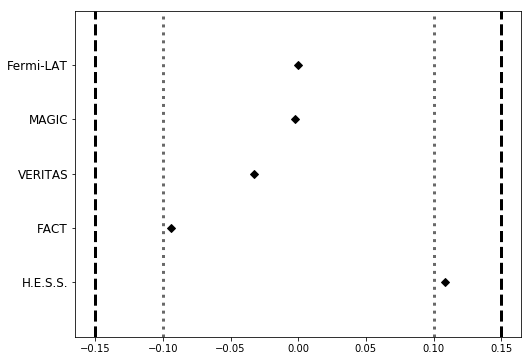

In [9]:
z_fermi = m.values["z_fermi"]
z_magic = m.values["z_magic"]
z_veritas = m.values["z_veritas"]
z_hess = m.values["z_hess"]
z_fact = m.values["z_fact"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(z_fermi, 5, ls="-", marker="D", color="k")
ax.plot(z_magic, 4, ls="-", marker="D", color="k")
ax.plot(z_veritas, 3, ls="-", marker="D", color="k")
ax.plot(z_fact, 2, ls="-", marker="D", color="k")
ax.plot(z_hess, 1, ls="-", marker="D", color="k")

ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(
    ["H.E.S.S.", "FACT", "VERITAS", "MAGIC", "Fermi-LAT"], fontsize=12
)
ax.set_ylim([0, 6])
ax.axvline(0.15, color="k", lw=3, ls="--")
ax.axvline(-0.15, color="k", lw=3, ls="--")
ax.axvline(0.10, color="dimgray", lw=3, ls=":")
ax.axvline(-0.10, color="dimgray", lw=3, ls=":")